## Camera Calibration

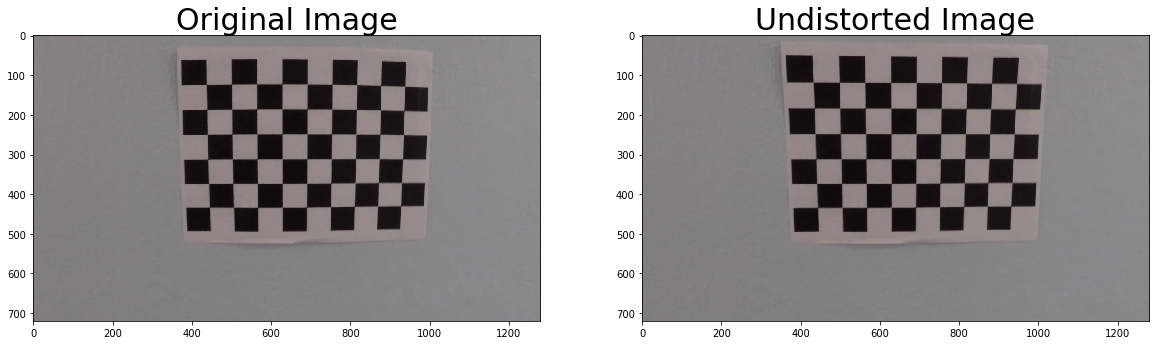

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# the first two dimesions are x and y and the last one is z which we put zero since we are talking about plain.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Calculating mtx and dist matrices that we need
img_test = cv2.imread('camera_cal/calibration18.jpg')
img_size = (img_test.shape[1], img_test.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Testing on an image to undistort the image
dst_image = cv2.undistort(img_test, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst_image)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst_image)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.destroyAllWindows()

## Applying distortion correction to raw images

In [3]:
raw_images = glob.glob('test_images/straight_lines2.jpg')
# Creating an empty list to put all undistorted images in it
undist_images = []
for idx, fname in enumerate(raw_images):
    img = cv2.imread(fname)
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    undist_images.append(undist_image)


## Creating Thresholded Binary Images

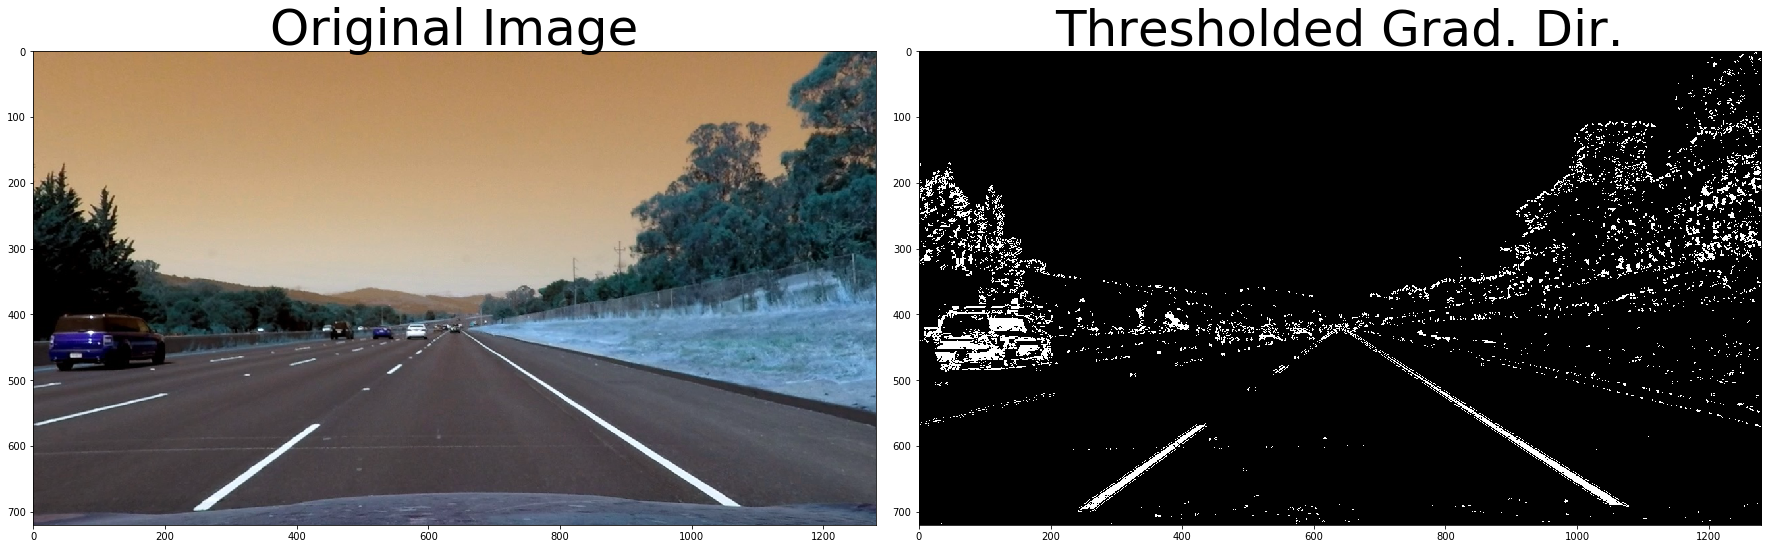

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline


# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobelX) + np.square(sobelY))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelX)
    abs_sobely = np.absolute(sobelY)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    artan_mag = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(artan_mag)
    binary_output[(artan_mag >= thresh[0]) & (artan_mag <= thresh[1])] = 1
    return binary_output
def color_channel(img, s_thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary
# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements
combined_binaries = []
# Apply each of the thresholding functions
for image in undist_images:
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.6, 1.3))
    color_binary = color_channel(image)
    # Combined gradients
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Combine gradients with color
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(combined_grad == 1) | (color_binary == 1)] = 1
    combined_binaries.append(combined_binary)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined_binary, cmap='gray')
    ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Applying Perspective Transform

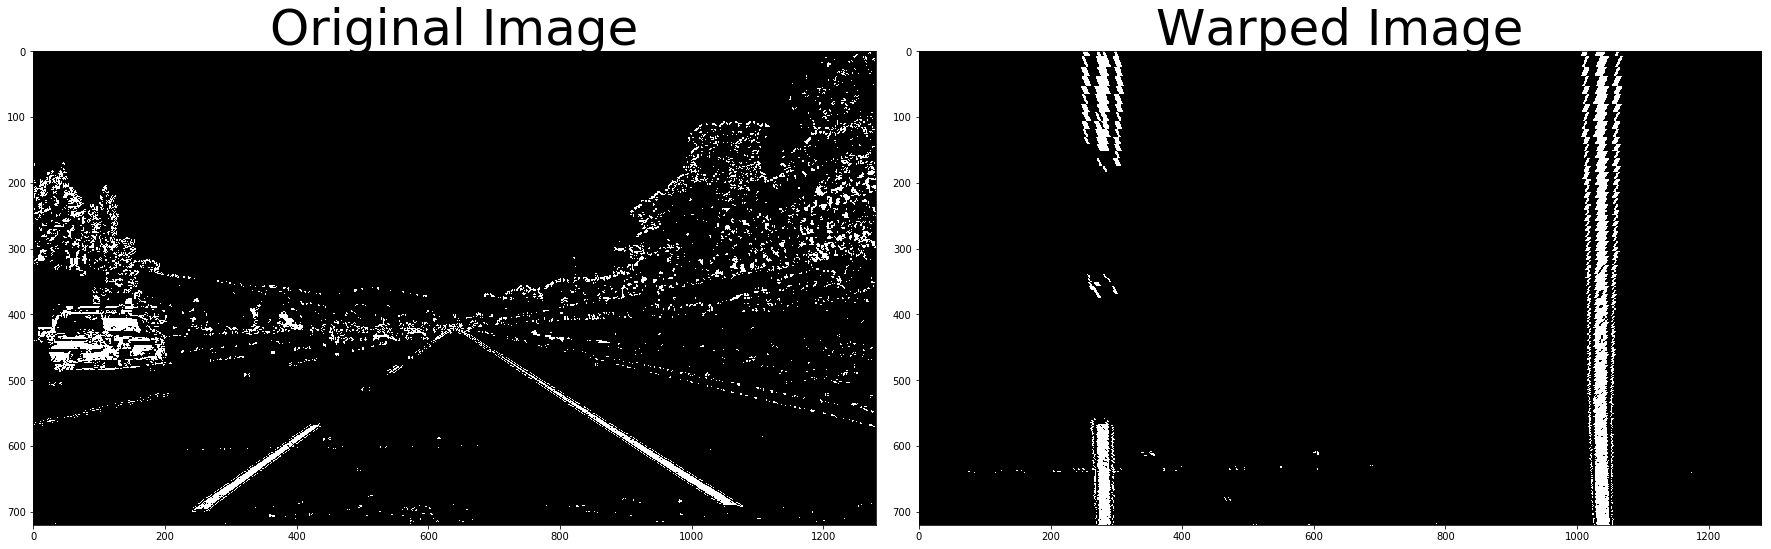

In [5]:
# First element is for x axis and second element is for y axis
src = [[581, 477],[699, 477],[896, 675],[384, 675]]
dst = [[384, 0],[896, 0],[896, 720],[384, 720]]
src = np.float32(src)
dst = np.float32(dst)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
def warper(img, M):
    # apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped
def De_warper(img, Minv):
    # apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped
image = combined_binaries[0]
warped = warper(image, M)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
image = np.dstack((image, image, image))
warped = np.dstack((warped, warped, warped))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detecting lane pixels and fit to find the lane boundary

(720, 0)

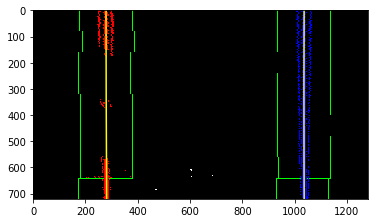

In [6]:
# selecting one of the binary images in order to detect lane pixels
binary_warped = warper(combined_binaries[0], M)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
out_img = out_img.astype(np.uint8)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
######Visualization######
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
fig = plt.figure()
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img, cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Determine the curvature of the lane and vehicle position with respect to center <br></br>

In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


47885.5289171 m 30240.1086116 m


 ## Warp Back  and Output  Lane Boundaries <br></br>
 
 

(720, 1280, 3)


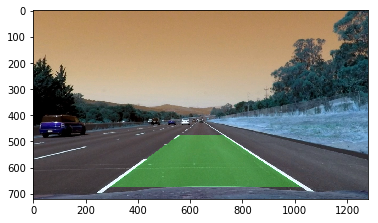

In [8]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
# color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
print (warp_zero.shape)
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_images[0], 1, newwarp, 0.3, 0)
plt.imshow(result)


In [14]:
# code for finding the center was acquired from https://github.com/thomasantony/CarND-P04-Advanced-Lane-Lines/blob/master/Project04.ipynb

def lane_line_pixel(combined_binary):
    # selecting one of the binary images in order to detect lane pixels
    binary_warped = warper(combined_binary, M)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#         (0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#         (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ######Visualization######
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty
    

In [26]:
import numpy as np
import cv2
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # x values for recent frames
        # y values for recent 
        self.recent_fit = []
        self.count = -1
        self.frames = 0
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobelX) + np.square(sobelY))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelX)
    abs_sobely = np.absolute(sobelY)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    artan_mag = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(artan_mag)
    binary_output[(artan_mag >= thresh[0]) & (artan_mag <= thresh[1])] = 1
    return binary_output
def color_channel(img, s_thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary
def image_grad_color(image):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.6, 1.3))
    color_binary = color_channel(image)
    # Combined gradients
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Combine gradients with color
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(combined_grad == 1) | (color_binary == 1)] = 1
    return combined_binary
def warper(img, M):
    # apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped
def warp_mat():
    src = [[581, 477],[699, 477],[896, 675],[384, 675]]
    dst = [[384, 0],[896, 0],[896, 720],[384, 720]]
    src = np.float32(src)
    dst = np.float32(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv
def lane_line(binary_warped):
    # selecting one of the binary images in order to detect lane pixels
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#         (0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#         (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    return leftx, lefty, rightx, righty

def lane_line_partial(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    return leftx, lefty, rightx, righty

def curvature_vehicle(left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def warp_back(warped, undist_image, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_image.shape[1], undist_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return result


M, Minv = warp_mat()
lost_frames = 0
def process_image(video_frame):
    ksize = 9
    M = warp_mat()[0]
    Minv = warp_mat()[1]
#     img = cv2.imread(video_frame)
    img = video_frame
    with open('camera_cal_pickle.p', 'rb') as handle:
        dist_pickle = pickle.load(handle)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    gradx = abs_sobel_thresh(undist_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(undist_image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(undist_image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undist_image, sobel_kernel=ksize, thresh=(0.6, 1.3))
    color_binary = color_channel(undist_image)
    # Combined gradients
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Combine gradients with color
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(combined_grad == 1) | (color_binary == 1)] = 1
    binary_warped = warper(combined_binary, M)
    if left_class.detected == True and right_class.detected == True:
        leftx, lefty, rightx, righty = lane_line_partial(binary_warped, left_class.current_fit, right_class.current_fit)
        len_left = int(leftx.shape[0]/2)
        len_right = int(rightx.shape[0]/2)
        bottom_half = np.int(np.mean(rightx[0:len_right])) - np.int(np.mean(leftx[0:len_left]))
        top_half = np.int(np.mean(rightx[len_right:])) - np.int(np.mean(leftx[len_left:]))
        if  abs(top_half - bottom_half) < 50:
            left_class.detected = True
            right_class.detected = True
    elif left_class.count == -1 or left_class.count > 5:
        leftx, lefty, rightx, righty = lane_line(binary_warped)
        len_left = int(leftx.shape[0]/2)
        len_right = int(rightx.shape[0]/2)
        bottom_half = np.int(np.mean(rightx[0:len_right])) - np.int(np.mean(leftx[0:len_left]))
        top_half = np.int(np.mean(rightx[len_right:])) - np.int(np.mean(leftx[len_left:]))
        if  abs(top_half - bottom_half) < 50:
            left_class.detected = True
            right_class.detected = True
            left_class.count = 0
            right_class.count = 0
    if left_class.detected and right_class.detected:
        left_class.count = 0
        right_class.count = 0
        if len(left_class.recent_fit) < 10:
            left_class.recent_fit.append(np.polyfit(lefty, leftx, 2))
            right_class.recent_fit.append(np.polyfit(righty, rightx, 2))
        else:
            left_class.recent_fit.pop()
            left_class.recent_fit.append(np.polyfit(lefty, leftx, 2))
            right_class.recent_fit.pop()
            right_class.recent_fit.append(np.polyfit(righty, rightx, 2))
    else:
        left_class.count += 1
        right_class.count += 1
        left_class.detected = False
        right_class.detected = False
    # Fit a second order polynomial to each
    


    left_class.current_fit = np.mean(np.vstack(left_class.recent_fit), axis = 0)
    right_class.current_fit = np.mean(np.vstack(right_class.recent_fit), axis = 0)

    ######Visualization######
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_class.current_fit[0]*ploty**2 + left_class.current_fit[1]*ploty + left_class.current_fit[2]
    right_fitx = right_class.current_fit[0]*ploty**2 + right_class.current_fit[1]*ploty + right_class.current_fit[2]
    # left_class.
    # right_class.
    # calculating distance from center
    distX_per_pix = 3.7/700
    center_camera = binary_warped.shape[1]//2
    center = (left_class.current_fit[-1] + right_class.current_fit[-1])//2
    dist_center = (center_camera - center)*distX_per_pix

    result = warp_back(binary_warped, undist_image, left_fitx, right_fitx, ploty, Minv)
    
    if left_class.frames % 4 == 0:
        left_class.frames = 0
        left_class.radius_of_curvature, right_class.radius_of_curvature = curvature_vehicle(left_fitx, right_fitx, ploty)
    result = cv2.putText(result, "Curvature = "+str((left_class.radius_of_curvature+right_class.radius_of_curvature)//2),(50, 50),cv2.FONT_HERSHEY_COMPLEX_SMALL,.7,(0,0,255))
    result = cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dist_center), 'left' if dist_center < 0 else 'right'),(50,110), 
                        cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.7,(0,0,255))
    left_class.frames +=1
    return result
left_class = Line()
right_class = Line()

## Testing on the Video <br></br>

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_out.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:36<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



## Showing the output Video Here! <br></br>

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(write_output))